In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sbi.inference import NPE, simulate_for_sbi
import torch

from sbi import utils as sbi_utils
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [3]:
# Configuration
num_samples = 100
t_max = 20
num_timesteps = 64
num_masses = 4
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

In [4]:
# [WALL]--(k0,b0)--[m0]--(k1,b1)--[m1]--(k2,b2)--[m2]

# Define system of equations
def multi_mass_spring_damper(y, t, m, k, b, F_ext=None):
    """
    y: concatenated [x0, x1, ..., xn, v0, v1, ..., vn]
    m, k, b: arrays of length n
    F_ext: optional external force per mass at time t
    """
    n = len(m)
    x = y[:n]
    v = y[n:]
    
    dxdt = v
    dvdt = np.zeros(n)

    for i in range(n):
        # External force
        F = 0
        if F_ext is not None:
            F = np.interp(t, t_data, F_ext[i])

        # F = np.interp(t, t_data, x_data[0, :, 0])

        # Spring-damper forces from neighbors
        force = 0

        # Left spring/damper: wall or previous mass
        if i == 0: 
         force += -k[0] * x[0] - b[0] * v[0]  # connected to wall
        else:
            force += -k[i] * (x[i] - x[i-1]) - b[i] * (v[i] - v[i-1])

        # Right spring/damper: next mass if not last
        if i < n - 1:
            force += -k[i+1] * (x[i] - x[i+1]) - b[i+1] * (v[i] - v[i+1])

        dvdt[i] = (F + force) / m[i]

    return np.concatenate([dxdt, dvdt])


def multi_msd_simulator(params, F_ext=None):
    """
    params: [m0, m1, ..., k0, k1, ..., b0, b1, ...]
    """
    m = np.array(params[:num_masses])
    k = np.array(params[num_masses:2*num_masses])
    b = np.array(params[2*num_masses:3*num_masses])

    t = np.linspace(0, 10, num_timesteps)
    y0 = np.zeros(2 * num_masses)  # Initial positions and velocities

    sol = odeint(multi_mass_spring_damper, y0, t, args=(m, k, b, F_ext))

    x = sol[:, :num_masses]
    v = sol[:, num_masses:]

    return extract_summary_statistics_multimass(t, x, v)


def extract_summary_statistics_multimass(t, x, v):
    num_masses = x.shape[1]

    # Compute stats per mass
    stats = []
    for i in range(num_masses):
        stats.extend(extract_summary_statistics(t, x[:, i], v[:, i]))

    return np.array(stats)


def extract_summary_statistics(t, x, v):
    steady_state = x[-1]

    # Settling time
    settling_idx = np.where(np.abs(x - steady_state) <= 0.05 * np.abs(steady_state))[0]
    settling_time = t[settling_idx[0]] if len(settling_idx) > 0 else np.nan

    # Rise time (time to go from 10% to 90% of final value)
    try:
        rise_start = np.where(x >= 0.1 * steady_state)[0][0]
        rise_end = np.where(x >= 0.9 * steady_state)[0][0]
        rise_time = t[rise_end] - t[rise_start]
    except IndexError:
        rise_time = np.nan

    # Peak overshoot
    peak_overshoot = (np.max(x) - steady_state) / steady_state if steady_state != 0 else np.nan

    # Final position and velocity
    final_position = x[-1]
    final_velocity = v[-1]

    # Mean and variance of position and velocity (to handle randomness)
    mean_position = np.mean(x)
    var_position = np.var(x)
    mean_velocity = np.mean(v)
    var_velocity = np.var(v)
    energy = np.sum(x**2)
    max_rate_of_change = np.max(np.diff(x) / np.diff(t))

    # Combine all summary stats into a single vector
    summary_stats = np.array([
        settling_time, rise_time, peak_overshoot,
        final_position, final_velocity,
        mean_position, var_position,
        mean_velocity, var_velocity,
        energy, max_rate_of_change
    ])
    
    # Handle any NaNs with a fallback value (e.g., -1 or zero)
    summary_stats = np.nan_to_num(summary_stats, nan=-1)

    return summary_stats

def generate_deterministic_force(timesteps, seed=42, smoothing=2.0):
    rng = np.random.default_rng(seed)
    raw = rng.random(timesteps) - 0.5
    force = np.cumsum(raw)
    force = gaussian_filter1d(force, sigma=smoothing)
    return np.abs(force)

def simulator(params):
    # # Generate new force profile per sample
    
    # sample_idx = 0
    # F_shared = x_data[sample_idx, :, 0]
    # F_ext = np.tile(F_shared, (num_masses, 1))

    # Fixed random walk profile
    F_signal = generate_deterministic_force(num_timesteps)
    F_ext = np.tile(F_signal, (num_masses, 1)) 

    # F_ext = np.abs(np.cumsum(np.random.rand(num_masses, num_timesteps) - 0.5, axis=1))
    return multi_msd_simulator(params, F_ext=F_ext)

In [5]:
# Prior distribution for (m, k, b) — assuming you know rough ranges
num_params = 3 * num_masses 

prior = sbi_utils.BoxUniform(
    low=torch.tensor([0.1] * num_params),
    high=torch.tensor([10.0] * num_params)
)

prior, num_parameters, prior_returns_numpy = process_prior(prior)

simulator_wrapper = process_simulator(
    simulator,
    prior,
    prior_returns_numpy
)

check_sbi_inputs(simulator_wrapper, prior)

# Create inference object
inference = NPE(prior)

In [7]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=80000)

  0%|          | 0/80000 [00:00<?, ?it/s]

In [8]:
# Train the inference network
density_estimator = inference.append_simulations(theta, x).train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 385 epochs.

In [9]:
def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

In [12]:
def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

sample = prior.sample((1,))
observed_data = simulator(sample.numpy()[0])
observed_data = torch.tensor(observed_data, dtype=torch.float32)
# Infer parameters
samples = posterior.sample((100000,), x=observed_data)
params, labels = get_param_labels_and_values(samples, num_masses)
for i, label in enumerate(labels):
    print(f"T {label}: {sample[0][i]:.4f}, I {label}: {params[i]:.4f}")

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

T m0: 2.6686, I m0: 1.2822
T m1: 2.0971, I m1: 1.8482
T m2: 6.7105, I m2: 6.6739
T m3: 7.0445, I m3: 7.3355
T k0: 8.9364, I k0: 8.9337
T k1: 8.0535, I k1: 8.0627
T k2: 2.4469, I k2: 2.5524
T k3: 2.0161, I k3: 2.9081
T b0: 2.5307, I b0: 2.4148
T b1: 1.1618, I b1: 0.8576
T b2: 2.3618, I b2: 2.0479
T b3: 7.4164, I b3: 5.0301


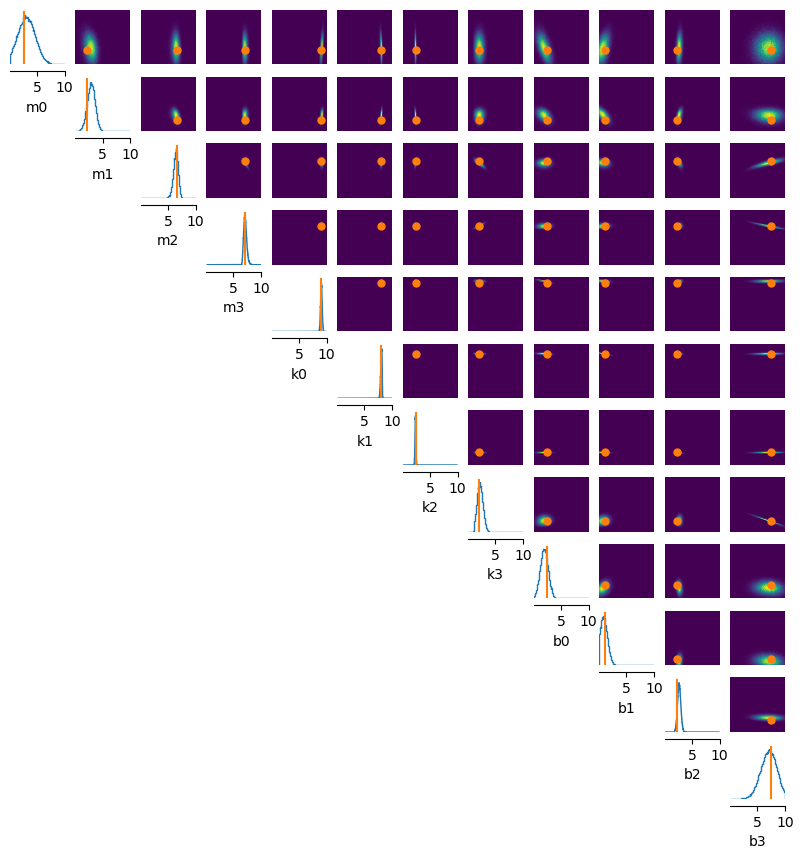

In [13]:
from sbi import analysis

fig, ax = analysis.pairplot(
    samples,
    points=sample,
    labels=labels,
    limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
)